# Deep Reinforcement Learning for Robotic Systems 

## Synopsis

This notebook outlines the modelling and integration of the **[Proximal Policy Optimisation](http://arxiv.org/abs/1707.06347)** algorithm on an **inverted double pendulum** as a baseline study into advanced astrodynamical control systems, such as docking and berthing of spacecraft, and rocket initialisation stabilisation. 

--------

Produced by *[Mughees Asif](https://github.com/mughees-asif)*, under the supervision of [Dr. Angadh Nanjangud](https://www.sems.qmul.ac.uk/staff/a.nanjangud) (Lecturer in Aerospace/Spacecraft Engineering @ [Queen Mary, University of London](https://www.sems.qmul.ac.uk/)).



## 1. Overview

Proximal Policy Optimisation is a deep reinforcement learning algorithm developed by [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html). It has proven to be successful in a variety of tasks ranging from enabling robotic systems in complex environments, to developing proficiency in computer gaming by using stochastic mathematical modelling to simulate real-life decision making. For the purposes of this research, the algorithm will be implemented to vertically stablise an inverted double pendulum, which is widely used in industry as a benchmark to validate the veracity of next-generation intelligent algorithms.

## 2. Model description

An inverted double pendulum is a characteristic example of a simple-to-build, non-linear, and chaotic mechanical system that has been widely studied in the fields of Robotics, Aerospace, Biomedical, Mechanical Engineering, and Mathematical Analysis.

<img src="images/dip_fbd.png" width="350" />

## 3. Variables

<img src="images/variables.png" width="400" />

## 4. Governing equations of motion

The following section utilises the [SymPy](https://www.sympy.org/en/index.html) package to derive the governing equations of motion. 

### 4.1. Basic modelling

<img src="images/dip_fbd_radius.png" width="300" />

In [ ]:
# necessary imports

# mathematical
import sympy

# computational



In [1]:
# initiliase variables
t = sympy.symbols('t')        # time
m = sympy.symbols('m')        # mass of the cart
l = sympy.symbols('l')        # length of the pendulums, l_1 = l_2 = l
M = sympy.symbols('M')        # mass of the pendulums, M_1 = M_2 = M
I = sympy.symbols('I')        # moment of inertia
g = sympy.symbols('g')        # gravitational constant, 9.81 m/s^2
F = sympy.symbols('F')        # force applied to the cart

x = sympy.Function('x')(t)    # |
Θ = sympy.Function('Θ')(t)    # | --- functions of (t)
Φ = sympy.Function('Φ')(t)    # |

# cart
x_dot = x.diff(t)             # velocity

# pendulum(s) 
x_1 = x + (l*sympy.sin(Θ))    # | --- position
x_2 = l*sympy.cos(Θ)          # | 

v_1 = x_1 + l*sympy.sin(Φ)                                             # |
v_2 = x_2 + l*sympy.cos(Φ)                                             # | --- linear velocity
v_3 = sympy.sqrt(sympy.simplify(x_1.diff(t)**2 + x_2.diff(t)**2))      # |  
v_4 = sympy.sqrt(sympy.simplify(v_1.diff(t)**2 + v_2.diff(t)**2))      # |

Θ_dot = Θ.diff(t)             # | --- angular velocity
Φ_dot = Φ.diff(t)             # |

### 4.2. Kinetic and Potential Energy

In [2]:
# kinetic energy 
K = 0.5*((m*x_dot**2) + M*(v_3**2 + v_4**2) + I*(Θ_dot**2 + Φ_dot**2))

# potential energy 
P = M*g*l*(2*sympy.cos(Θ) + sympy.cos(Φ))

In [3]:
print('------------------------------\nThe kinetic energy, K, of the system:\n------------------------------')
K

------------------------------
The kinetic energy, K, of the system:
------------------------------


0.5*I*(Derivative(Θ(t), t)**2 + Derivative(Φ(t), t)**2) + 0.5*M*(2*l**2*cos(Θ(t) - Φ(t))*Derivative(Θ(t), t)*Derivative(Φ(t), t) + 2*l**2*Derivative(Θ(t), t)**2 + l**2*Derivative(Φ(t), t)**2 + 4*l*cos(Θ(t))*Derivative(x(t), t)*Derivative(Θ(t), t) + 2*l*cos(Φ(t))*Derivative(x(t), t)*Derivative(Φ(t), t) + 2*Derivative(x(t), t)**2) + 0.5*m*Derivative(x(t), t)**2

In [4]:
print('------------------------------\nThe potential energy, P, of the system:\n------------------------------')
P

------------------------------
The potential energy, P, of the system:
------------------------------


M*g*l*(2*cos(Θ(t)) + cos(Φ(t)))

### 4.3. The Lagrangian

The action $S$ of the cart (movement; left, right) is mathematically defined as:

$$S = \int_{t_{0}}^{t_{1}} K - P \,dt$$

but, $L = K - P$

$$\therefore S = \int_{t_{0}}^{t_{1}} L \,dt$$

In [5]:
# the lagrangian
L = K - P

print('------------------------------\nThe Lagrangian of the system is:\n------------------------------')
L

------------------------------
The Lagrangian of the system is:
------------------------------


0.5*I*(Derivative(Θ(t), t)**2 + Derivative(Φ(t), t)**2) - M*g*l*(2*cos(Θ(t)) + cos(Φ(t))) + 0.5*M*(2*l**2*cos(Θ(t) - Φ(t))*Derivative(Θ(t), t)*Derivative(Φ(t), t) + 2*l**2*Derivative(Θ(t), t)**2 + l**2*Derivative(Φ(t), t)**2 + 4*l*cos(Θ(t))*Derivative(x(t), t)*Derivative(Θ(t), t) + 2*l*cos(Φ(t))*Derivative(x(t), t)*Derivative(Φ(t), t) + 2*Derivative(x(t), t)**2) + 0.5*m*Derivative(x(t), t)**2

### 4.4. The Euler-Lagrange equations

The standard [Euler-Lagrange equation](https://www.ucl.ac.uk/~ucahmto/latex_html/chapter2_latex2html/node5.html) is:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = 0$$

To introduce the generalised force acting on the cart, the [Lagrange-D'Alembert Principle](https://en.wikipedia.org/wiki/D%27Alembert%27s_principle) is used:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = Q^{P}$$

Therefore, for a three-dimensional _working_ system, the equations of motion can be derived as:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = F - \dot x$$
$$\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = 0$$
$$\frac{d}{dt}\frac{\partial L}{\partial \dot{\phi}} - \frac{\partial L}{\partial \phi} = 0$$

In [6]:
# euler-lagrange formulation
euler_1 = sympy.Eq((L.diff(x_dot).diff(t) - L.diff(x)).simplify().expand().collect(x.diff(t, t)), F - x.diff(t))
euler_2 = sympy.Eq((L.diff(Θ_dot).diff(t) - L.diff(Θ)).simplify().expand().collect(Θ.diff(t, t)), 0)
euler_3 = sympy.Eq((L.diff(Φ_dot).diff(t) - L.diff(Φ)).simplify().expand().collect(Φ.diff(t, t)), 0)

print('------------------------------\nThe Euler-Lagrange equations:\n------------------------------\n1.')
euler_1

------------------------------
The Euler-Lagrange equations:
------------------------------
1.


Eq(-2*M*l*sin(Θ(t))*Derivative(Θ(t), t)**2 - M*l*sin(Φ(t))*Derivative(Φ(t), t)**2 + 2*M*l*cos(Θ(t))*Derivative(Θ(t), (t, 2)) + M*l*cos(Φ(t))*Derivative(Φ(t), (t, 2)) + (2*M + 1.0*m)*Derivative(x(t), (t, 2)), F - Derivative(x(t), t))

In [7]:
print('2.')
euler_2

2.


Eq(-2.0*M*g*l*sin(Θ(t)) + 1.0*M*l**2*sin(Θ(t) - Φ(t))*Derivative(Φ(t), t)**2 + 1.0*M*l**2*cos(Θ(t) - Φ(t))*Derivative(Φ(t), (t, 2)) + 2.0*M*l*cos(Θ(t))*Derivative(x(t), (t, 2)) + (1.0*I + 2.0*M*l**2)*Derivative(Θ(t), (t, 2)), 0)

In [8]:
print('3.')
euler_3

3.


Eq(-1.0*M*g*l*sin(Φ(t)) - 1.0*M*l**2*sin(Θ(t) - Φ(t))*Derivative(Θ(t), t)**2 + 1.0*M*l**2*cos(Θ(t) - Φ(t))*Derivative(Θ(t), (t, 2)) + 1.0*M*l*cos(Φ(t))*Derivative(x(t), (t, 2)) + (1.0*I + 1.0*M*l**2)*Derivative(Φ(t), (t, 2)), 0)

### 4.5. Linearisation and acceleration

[Hartman-Grobman theorem](https://en.wikipedia.org/wiki/Hartman%E2%80%93Grobman_theorem)

The pendulum will achieve equilibrium when vertical, i.e. $\theta=0$ & $\phi=0$:

$$\sin(\theta)=\theta, \quad \cos(\theta)=1, \quad \dot\theta^{2}=0$$

$$\sin(\phi)=\phi, \quad \cos(\phi)=1, \quad \dot\phi^{2}=0$$

$$\sin(\theta - \phi)=\theta - \phi, \quad\quad \cos(\theta - \phi)=1$$

In [9]:
# linearise the system
matrix = [(sympy.sin(Θ), Θ), (sympy.cos(Θ), 1), (Θ_dot**2, 0), 
         (sympy.sin(Φ), Φ), (sympy.cos(Φ), 1), (Φ_dot**2, 0),
         (sympy.sin(Θ - Φ), Θ - Φ), (sympy.cos(Θ - Φ), 1)]

linear_1 = euler_1.subs(matrix)
linear_2 = euler_2.subs(matrix)
linear_3 = euler_3.subs(matrix)

print('------------------------------\nThe linear equations are: \n------------------------------\n1.')
linear_1

------------------------------
The linear equations are: 
------------------------------
1.


Eq(2*M*l*Derivative(Θ(t), (t, 2)) + M*l*Derivative(Φ(t), (t, 2)) + (2*M + 1.0*m)*Derivative(x(t), (t, 2)), F - Derivative(x(t), t))

In [10]:
print('2. ')
linear_2

2. 


Eq(-2.0*M*g*l*Θ(t) + 1.0*M*l**2*Derivative(Φ(t), (t, 2)) + 2.0*M*l*Derivative(x(t), (t, 2)) + (1.0*I + 2.0*M*l**2)*Derivative(Θ(t), (t, 2)), 0)

In [11]:
print('3. ')
linear_3

3. 


Eq(-1.0*M*g*l*Φ(t) + 1.0*M*l**2*Derivative(Θ(t), (t, 2)) + 1.0*M*l*Derivative(x(t), (t, 2)) + (1.0*I + 1.0*M*l**2)*Derivative(Φ(t), (t, 2)), 0)

In [12]:
# simplify for linear and angular acceleration
final_equations = sympy.linsolve([linear_1, linear_2, linear_3], [x.diff(t, t), Θ.diff(t, t), Φ.diff(t, t)])

x_ddot = final_equations.args[0][0].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()
Θ_ddot = final_equations.args[0][1].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()
Φ_ddot = final_equations.args[0][2].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()

print('------------------------------\nx_acceleration:\n------------------------------')
x_ddot      

------------------------------
x_acceleration:
------------------------------


(F*(4.0*I**2 + 12.0*I*M*l**2 + 4.0*M**2*l**4) - 4.0*I*M**2*g*l**2*Φ(t) - M**2*g*l**2*(16.0*I + 8.0*M*l**2)*Θ(t) - (4.0*I**2 + 12.0*I*M*l**2 + 4.0*M**2*l**4)*Derivative(x(t), t))/(8.0*I**2*M + 4.0*I**2*m + 4.0*I*M**2*l**2 + 12.0*I*M*l**2*m + 4.0*M**2*l**4*m)

In [13]:
print('------------------------------\nΘ_acceleration:\n------------------------------')
Θ_ddot

------------------------------
Θ_acceleration:
------------------------------


M*l*(-F*(8.0*I + 4.0*M*l**2) - 4.0*M*g*l**2*m*Φ(t) + g*(16.0*I*M + 8.0*I*m + 8.0*M**2*l**2 + 8.0*M*l**2*m)*Θ(t) + (8.0*I + 4.0*M*l**2)*Derivative(x(t), t))/(8.0*I**2*M + 4.0*I**2*m + 4.0*I*M**2*l**2 + 12.0*I*M*l**2*m + 4.0*M**2*l**4*m)

In [14]:
print('------------------------------\nΦ_acceleration:\n------------------------------')
Φ_ddot         

------------------------------
Φ_acceleration:
------------------------------


M*l*(-1.0*F*I + 1.0*I*Derivative(x(t), t) - 2.0*M*g*l**2*m*Θ(t) + g*(2.0*I*M + 1.0*I*m + 2.0*M*l**2*m)*Φ(t))/(2.0*I**2*M + 1.0*I**2*m + 1.0*I*M**2*l**2 + 3.0*I*M*l**2*m + 1.0*M**2*l**4*m)

## 5. Proximal Policy Optimisation

### 5.1. Overview[<sup>1</sup>](#fn1)
 
 * State-of-the-art Policy Gradient method.
 * An on-policy algorithm.
 * Can be used for environments with either discrete or continuous action spaces.
 * **PPO-Clip** doesn’t have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.
 
<sup>1</sup><span id="fn1"></span>Referenced from [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html) 

### 5.2. PPO-Clip mathematical model

$$ \begin{equation}\mathbf{
 L^{PPO} (\theta)=\mathbb{\hat{E}}_t\:[L^{CLIP}(\theta)-c_1L^{VF}(\theta)+c_2S[\pi_\theta](s_t)]}
 \end{equation}$$ 
 
1. $ L^{CLIP} (\theta)=\mathbb{\hat{E}}_t[\min(r_t(\theta)\:\hat{A}^t,\:\:clip(r_t(\theta),\:\:1-\epsilon,\:\:1+\epsilon)\hat{A}^t)]$ 
<br>*where*,
* $r_t(\theta)\:\hat{A}^t$: Surrogate objective is the probability ratio between a new policy network and an older policy network.

* $\epsilon$: Hyper-parameter; usually with a value of 0.2.

* clip$(r_t(\theta),\:\:1-\epsilon,\:\:1+\epsilon)\:\hat{A}^t$: Clipped version of the surrogate objective, where the probability ratio is truncated.

2. $c_1L^{VF}(\theta)$: Determines desirability of the current state.

3. $c_2S[\pi_\theta](s_t)$: The entropy term using Gaussian Distribution.

In [15]:
# necessary imports
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from multiprocessing import Process, Pipe
from IPython.display import clear_output
from multiprocessing import Process, Pipe
import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

### 5.3. Environment

In [16]:
from common.multiprocessing_env import SubprocVecEnv
    
num_envs = 10
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

### 5.4. Neural Network

In [17]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.x_label('frame')
    plt.y_label('rewards')
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

### 5.5. Generalised Advantage Estimation

\begin{align}
\hat{A}_t^{GAE(\gamma,\lambda)} &= (1-\lambda)\Big(\hat{A}_{t}^{(1)} + \lambda \hat{A}_{t}^{(2)} + \lambda^2 \hat{A}_{t}^{(3)} + \cdots \Big) \\
&= (1-\lambda)\Big(\delta_t^V + \lambda(\delta_t^V + \gamma \delta_{t+1}^V) + \lambda^2(\delta_t^V + \gamma \delta_{t+1}^V + \gamma^2 \delta_{t+2}^V)+ \cdots \Big)  \\
&= (1-\lambda)\Big( \delta_t^V(1+\lambda+\lambda^2+\cdots) + \gamma\delta_{t+1}^V(\lambda+\lambda^2+\cdots) + \cdots \Big) \\
&= (1-\lambda)\left(\delta_t^V \frac{1}{1-\lambda} + \gamma \delta_{t+1}^V\frac{\lambda}{1-\lambda} + \cdots\right) \\
&= \sum_{l=0}^\infty (\gamma \lambda)^l \delta_{t+l}^{V}
\end{align}

In [18]:
def compute_gae(next_value, rewards, masks, values, gamma=0.95, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

### 5.6. PPO-Clip computational model[<sup>1</sup>](#fn1)

<sup>1</sup><span id="fn1"></span>Referenced from [Dulat Yerzat et al.](https://github.com/higgsfield/RL-Adventure-2) 

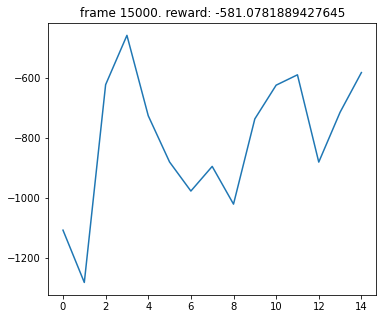

In [19]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

max_frames = 15000
frame_idx  = 0
test_rewards = []

state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

In [20]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

episodes = []
rewards = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
        episodes.append(i_episode)
        rewards.append(total_reward)
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
        
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()

episode: 0 reward: -136.77784049428172
episode: 1 reward: -288.426898608528
episode: 2 reward: -292.18639181438755
episode: 3 reward: -993.6414409145099
episode: 4 reward: -473.1517676572369
episode: 5 reward: -412.6210106071186
episode: 6 reward: -398.39510977149035
episode: 7 reward: -1125.853926707295
episode: 8 reward: -1.8327026192452893
episode: 9 reward: -425.7066532296286
episode: 10 reward: -280.54888650802906
episode: 11 reward: -401.01689827469744
episode: 12 reward: -271.70255636314425
episode: 13 reward: -1269.3381297914677
episode: 14 reward: -1070.7490302897472
episode: 15 reward: -441.87600834285325
episode: 16 reward: -128.61836217587174
episode: 17 reward: -293.10616765128276
episode: 18 reward: -267.264708774863
episode: 19 reward: -134.19957382164628
episode: 20 reward: -272.85120981095486
episode: 21 reward: -1221.1038641356736
episode: 22 reward: -1.1429558479294502
episode: 23 reward: -1.8343835895918466
episode: 24 reward: -0.9514564144902589
episode: 25 reward:

episode: 207 reward: -1.0564220368447437
episode: 208 reward: -946.3096622289894
episode: 209 reward: -137.99277189599275
episode: 210 reward: -1115.9102270440512
episode: 211 reward: -1027.0476032003917
episode: 212 reward: -1.4896918537656394
episode: 213 reward: -134.4334161588574
episode: 214 reward: -271.9643951408825
episode: 215 reward: -135.7256320476111
episode: 216 reward: -904.7523043566443
episode: 217 reward: -137.97212512447487
episode: 218 reward: -1.5960570381738044
episode: 219 reward: -275.1054279120781
episode: 220 reward: -279.39126036041006
episode: 221 reward: -563.6320606511811
episode: 222 reward: -1092.5905243230734
episode: 223 reward: -1228.6136836241783
episode: 224 reward: -266.0056178663609
episode: 225 reward: -283.07023862685924
episode: 226 reward: -407.4588870127468
episode: 227 reward: -952.665116387911
episode: 228 reward: -1236.0628606387559
episode: 229 reward: -1046.3312524525172
episode: 230 reward: -275.7981879581714
episode: 231 reward: -132.31

In [21]:
print(episodes)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [22]:
print(rewards)

[-1.959329628769218, -3.7805452932879966, -5.559625992131364, -7.39081353972039, -9.371105569245259, -11.604610557505461, -14.206179463890848, -17.30351859221369, -21.036713230507814, -25.55392288256198, -31.00223804824718, -37.513652948097395, -45.18394375508894, -54.4334007910374, -65.56042427267448, -77.98254147049377, -89.01189836952359, -98.56961697701344, -106.63901847994198, -113.27897236937982, -118.61722344225483, -122.82753755833076, -126.10161827507669, -128.6255641181308, -130.5652826746777, -132.060606420591, -133.22492612905884, -134.13739137472845, -134.86290868786705, -135.4234207050364, -135.73923687239014, -135.9028376625233, -136.01487427871854, -136.06377990210032, -136.09046945774548, -136.12094715781123, -136.1284677774088, -136.13199966521987, -136.13623275915424, -136.14165737602661, -136.14394772602844, -136.14537771126174, -136.14584732501177, -136.146135086988, -136.1468658695292, -136.1486263543992, -136.15018864441228, -136.15315269662216, -136.157092299812